In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import json
import numpy as np
import pandas as pd
from scipy.constants import golden
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
%config Completer. use_jedi = False

In [5]:
plt.rcParams['font.size'] = 14

In [6]:
BASE_PATH = '../../covid19-opendata-vaccini/dati'

START_DATE = '2021-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

AGE_ORDER = ['12-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
AGE_ORDER = ['12-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

FOOTNOTE = 'Grafico @RaffoRaffo85 | Dati aggiornati {}'.format(END_DATE)

# Utils

In [7]:
def extend_class(cls):
    """Source: https://gist.github.com/victorlei/5968685"""
    return lambda f: (setattr(cls,f.__name__,f) or f)

@extend_class(sns.FacetGrid)
def set_xdates(self, start, end, fmt='%b \'%y', freq='MS'):
    dt = pd.date_range(start, end, freq=freq)
    self.set(xticks=dt, xticklabels=dt.map(lambda x: x.strftime(fmt)))
    return self

@extend_class(sns.FacetGrid)
def set_suptitle(self, s, x=0, y=1.1, fontsize=18, ha='left'):
    self.fig.suptitle(s, x=x, y=y, ha=ha, fontweight='bold', fontsize=fontsize)
    return self

@extend_class(sns.FacetGrid)
def set_subtitle(self, s, x=0, y=1, c='darkgrey', fs=18, fw='bold', ha='left'):
    if isinstance(c, int):
        c = sns.color_palette('colorblind')[c]
    g.fig.text(x, y, s, color=c, fontsize=fs, fontweight=fw, ha=ha)

@extend_class(sns.FacetGrid)
def set_formatter(self, axis='xaxis', denom=1e6, fmt='{}'):
    if denom > 1:
        f = lambda x, pos: fmt.format(int(x/denom))
    else:
        f = lambda x, pos: fmt.format(x)
    for ax in self.axes.flat:
        getattr(ax, axis).set_major_formatter(FuncFormatter(f))
    return self

@extend_class(sns.FacetGrid)
def rm_y_axis(self):
    [ax.tick_params(axis='y', which=u'both',length=0) for ax in self.axes.flat]
    self.despine(left=True)
    return self

In [8]:
def collapse_to_80_plus(x):
    if x == '90+':
        return '80+'
    if x == '80-89':
        return '80+'
    return x

def get_complete_vacc(r):
    if r.fornitore == 'Janssen':
        return r.prima_dose
    return r.seconda_dose

def get_got_first_no_jansen(r):
    if r.fornitore == 'Janssen':
        return 0
    return r.prima_dose

def get_in_attesa_seconda(r):
    if r.fornitore == 'Janssen':
        return 0
    return r.prima_dose - r.seconda_dose

In [9]:
def get_daily_vacc_by_dim(df, dims=None, by_dose=True, rolling=7):
    dims_1 = 'date' if dims is None else ['date', *dims]
    tmp = (
        df
        .assign(date=lambda x: pd.to_datetime(x.data_somministrazione))
        .groupby(dims_1)
        [['solo_prima', 'ciclo_completo']]
        .sum()
        .reset_index()
        .melt(id_vars=dims_1, value_vars=['solo_prima', 'ciclo_completo'])
        .sort_values(dims_1)
        .reset_index(drop=True)
    )
    if not by_dose:
        if dims is None:
            smooth = lambda x: x.value.transform(lambda x: x.rolling(rolling, 1).mean())
        else:
            smooth = lambda x: x.groupby(dims).value.transform(lambda x: x.rolling(rolling, 1).mean())
        return (
            tmp
            .groupby(dims_1)[['value']].sum().reset_index()
            .assign(n_vacc=smooth)
        )
    if dims is None:
        smooth = lambda x: x.groupby(['variable']).value.transform(lambda x: x.rolling(rolling, 1).mean())
    else:
        smooth = lambda x: x.groupby([*dims, 'variable']).value.transform(lambda x: x.rolling(rolling, 1).mean())

    return (
        tmp
        .assign(n_vacc=smooth)
        .assign(dose=lambda x: x.variable.str.replace('_', ' '))
        .drop('variable', axis=1)
    )

# Load data

In [10]:
pop_by_age_df = (
    pd.read_csv(os.path.join(BASE_PATH, 'platea.csv'))
    .groupby('fascia_anagrafica')
    [['totale_popolazione']]
    .sum()
    .reset_index()
)

In [11]:
vacc_df = (
    pd.read_csv(os.path.join(BASE_PATH, 'somministrazioni-vaccini-latest.csv'))
    .drop(['codice_NUTS1', 'codice_NUTS2', 'codice_regione_ISTAT'], axis=1)
    .assign(fascia_anagrafica=lambda x: x.fascia_anagrafica.apply(collapse_to_80_plus))
    .assign(ciclo_completo=lambda x: x.apply(get_complete_vacc, axis=1))
    .assign(solo_prima=lambda x: x.apply(get_got_first_no_jansen, axis=1))
    .assign(in_attesa_seconda=lambda x: x.apply(get_in_attesa_seconda, axis=1))
)
vacc_df.shape # 89182, 11

(106454, 13)

In [12]:
vacc_df.data_somministrazione.max()

'2021-08-14'

# Daily vaccines

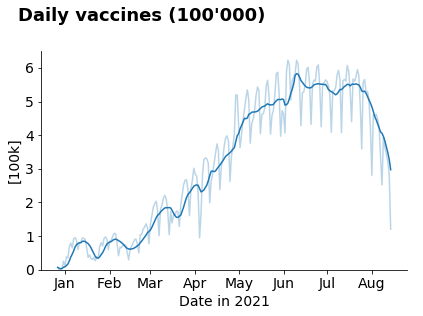

In [13]:
g = sns.FacetGrid(
    data=get_daily_vacc_by_dim(vacc_df, dims=None, by_dose=False, rolling=7), height=4, aspect=golden
)
g.map(sns.lineplot, 'date', 'value', alpha=.3)
g.map(sns.lineplot, 'date', 'n_vacc')
g.set_xdates(START_DATE, END_DATE, fmt='%b')
max_y_axis = 6.5e5+1
assert get_daily_vacc_by_dim(vacc_df, dims=None, by_dose=True, rolling=7)['value'].max() < max_y_axis
g.set(yticks=np.arange(0, max_y_axis, 1e5), ylim=(0, max_y_axis))
g.set_formatter(axis='yaxis', denom=1e5)
g.set_axis_labels(x_var='Date in 2021', y_var='[100k]')
g.add_legend()
g.set_suptitle('Daily vaccines (100\'000)', x=.15)

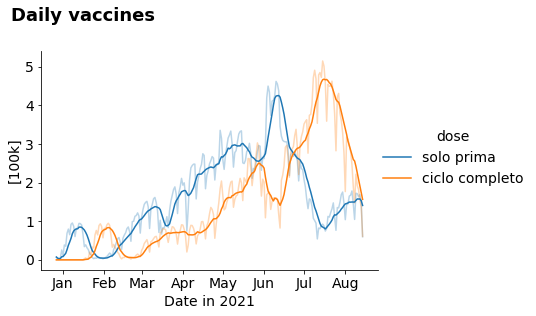

In [14]:
g = sns.FacetGrid(
    data=get_daily_vacc_by_dim(vacc_df, dims=None, by_dose=True, rolling=7), hue='dose', height=4, aspect=golden
)
g.map(sns.lineplot, 'date', 'value', alpha=.3)
g.map(sns.lineplot, 'date', 'n_vacc')
g.set_xdates(START_DATE, END_DATE, fmt='%b')
max_y_axis = 5.5e5+1
assert get_daily_vacc_by_dim(vacc_df, dims=None, by_dose=True, rolling=7)['value'].max() < max_y_axis
# g.set(yticks=np.arange(0, max_y_axis, 1e5), ylim=(0, max_y_axis))
g.set_formatter(axis='yaxis', denom=1e5)
g.set_axis_labels(x_var='Date in 2021', y_var='[100k]')
g.add_legend()
g.set_suptitle('Daily vaccines', x=.15)

# Age stratified

In [15]:
get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=False, rolling=7)['value'].max()

212111

## Daily total by age

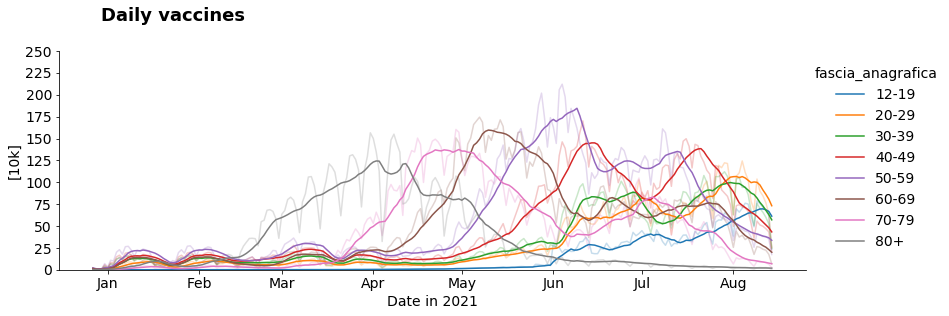

In [16]:
g = sns.FacetGrid(
    data=get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=False, rolling=7),
    hue='fascia_anagrafica', height=4, aspect=3, hue_order=AGE_ORDER
)
g.map(sns.lineplot, 'date', 'value', alpha=.25)
g.map(sns.lineplot, 'date', 'n_vacc')
g.set_xdates(START_DATE, END_DATE, fmt='%b')
max_y_axis = 25e4+1
assert get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=False, rolling=7)['value'].max() < max_y_axis
g.set(yticks=np.arange(0, max_y_axis, 25e3), ylim=(0, max_y_axis))
g.set_formatter(axis='yaxis', denom=1e3)
g.set_axis_labels(x_var='Date in 2021', y_var='[10k]')
g.add_legend()
g.set_suptitle('Daily vaccines', x=.15)

## Daily total by age and doses

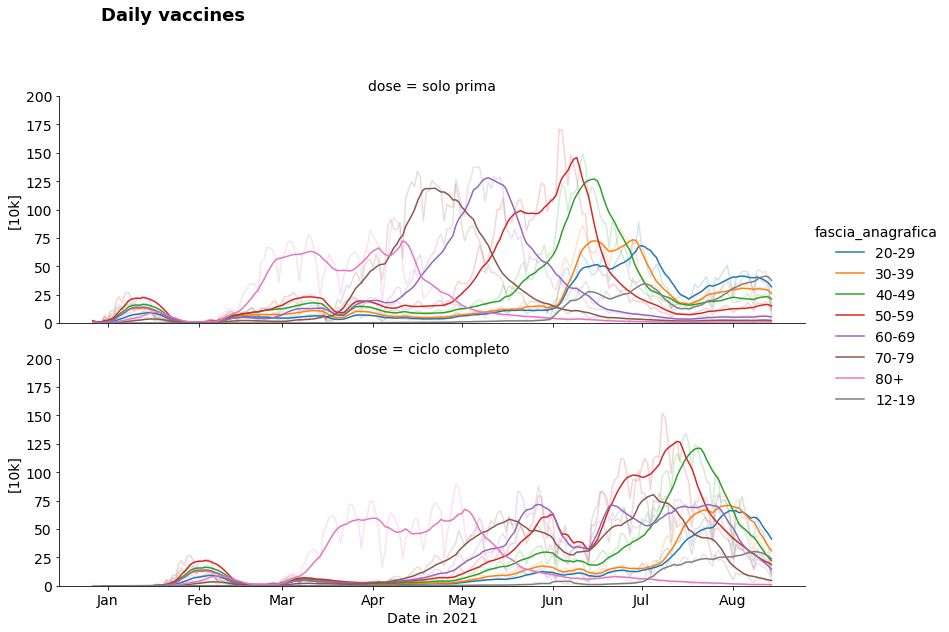

In [17]:
g = sns.FacetGrid(
    data=get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=True, rolling=7),
    hue='fascia_anagrafica', height=4, aspect=3, row='dose'
)
g.map(sns.lineplot, 'date', 'value', alpha=.2)
g.map(sns.lineplot, 'date', 'n_vacc')
g.set_xdates(START_DATE, END_DATE, fmt='%b')
max_y_axis = 20e4+1
assert get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=True, rolling=7)['value'].max() < max_y_axis
g.set(yticks=np.arange(0, max_y_axis, 25e3), ylim=(0, max_y_axis))
g.set_formatter(axis='yaxis', denom=1e3)
g.set_axis_labels(x_var='Date in 2021', y_var='[10k]')
g.add_legend()
g.set_suptitle('Daily vaccines', x=.15)

## Daily ridge-plot by age

In [18]:
def label(x, color, label, **kw):
    ax = plt.gca()
    if label in ['prima_dose', 'seconda_dose', 'prima', 'seconda', 'solo prima', 'ciclo completo']:
        label = ax.get_title().split(' | ')[0].split(' = ')[-1].strip()
    if kw.get('diff_hue', False):
        color = (0.538, 0.538, 0.538)
    ax.text(
        0, .2, label, fontsize=16, fontweight="bold", color=color,
        ha='left', va="center", transform=ax.transAxes
    )

/Users/raffaelerainone/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


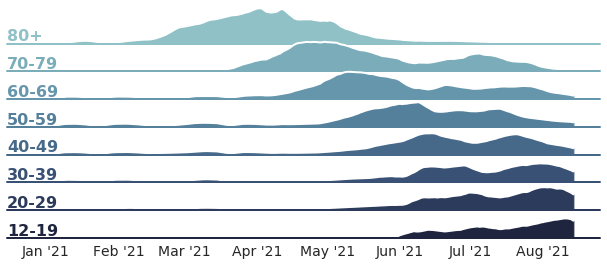

In [19]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    pal = sns.cubehelix_palette(len(AGE_ORDER), rot=-.25, light=.7)
    g = sns.FacetGrid(
        data=(
            get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=False, rolling=7)
            .merge(pop_by_age_df, on='fascia_anagrafica')
            .assign(share=lambda x: x.n_vacc*100/x.totale_popolazione)
            .assign(m=0)
        ),
        hue='fascia_anagrafica', hue_order=AGE_ORDER[::-1], row='fascia_anagrafica', row_order=AGE_ORDER[::-1],
        aspect=18, height=.5, palette=pal, sharey=True
    )
    g.map(plt.fill_between, 'date', 'm', 'share')
    g.map(sns.lineplot, 'date', 'share', color='w', lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    g.map(label, 'fascia_anagrafica')
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles('')
    g.set_axis_labels(x_var='', y_var='')
    g.set(yticks=[], ylim=(0, None))
    g.set_xdates(START_DATE, END_DATE, fmt='%b \'%y')
    g.despine(bottom=True, left=True)

## Daily ridge-plot by age and doses

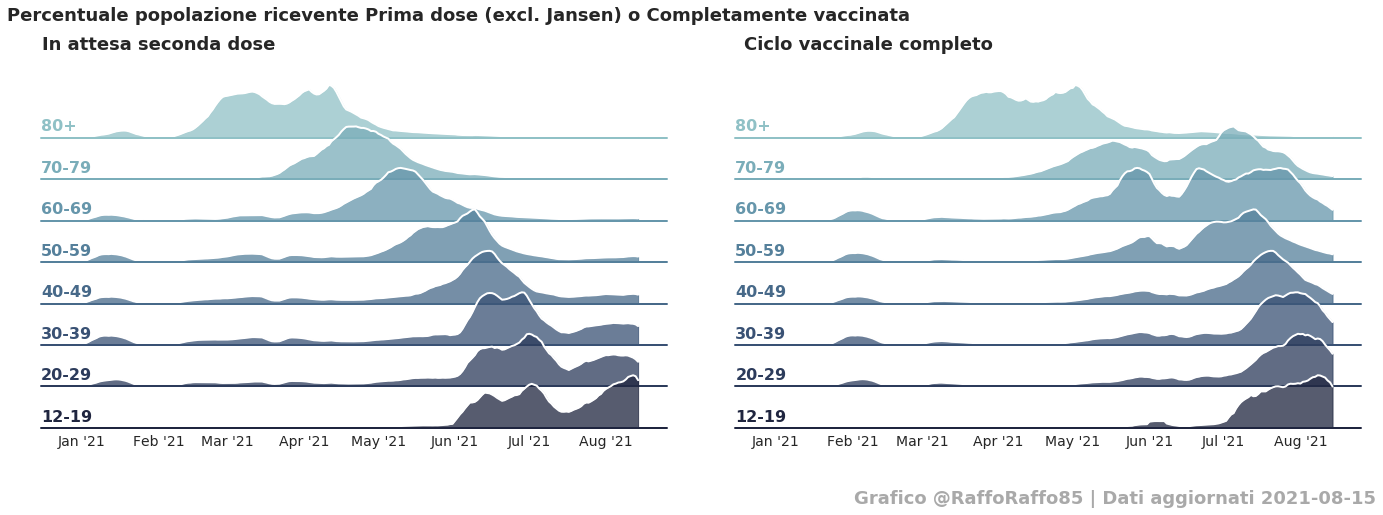

In [20]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    pal = sns.cubehelix_palette(len(AGE_ORDER), rot=-.25, light=.7)
    g = sns.FacetGrid(
        data=(
            get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=True, rolling=7)
            .merge(pop_by_age_df, on='fascia_anagrafica')
            .assign(share=lambda x: x.n_vacc*100/x.totale_popolazione)
            .assign(m=0)
        ),
        col='dose', col_order=['solo prima', 'ciclo completo'],
        hue='fascia_anagrafica', hue_order=AGE_ORDER[::-1],
        row='fascia_anagrafica', row_order=AGE_ORDER[::-1],
        aspect=13, height=.75, palette=pal,
        sharey=False
    )
    g.map(plt.fill_between, 'date', 'm', 'n_vacc', alpha=.75)
    g.map(sns.lineplot, 'date', 'n_vacc', color='w', lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    g.map(label, 'fascia_anagrafica', diff_hue=False)
    g.fig.subplots_adjust(hspace=-.25)
    g.fig.text(.05, 1, 'In attesa seconda dose', fontsize=18, fontweight='bold', ha='left')
    g.fig.text(.55, 1, 'Ciclo vaccinale completo', fontsize=18, fontweight='bold', ha='left')
    g.set_titles('')
    g.set_axis_labels(x_var='', y_var='')
    g.set(yticks=[], ylim=(-1, None))
    g.set_xdates(START_DATE, END_DATE, fmt='%b \'%y')
    g.despine(bottom=True, left=True)
    g.set_suptitle(
        'Percentuale popolazione ricevente Prima dose (excl. Jansen) o Completamente vaccinata',
        x=.025, y=1.1, ha='left'
    )
    g.set_subtitle(FOOTNOTE, x=1, y=-.05, ha='right')

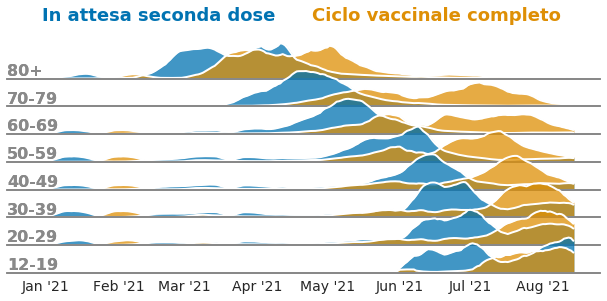

In [21]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(
        data=(
            get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=True, rolling=7)
            .merge(pop_by_age_df, on='fascia_anagrafica')
            .assign(share=lambda x: x.n_vacc*100/x.totale_popolazione)
            .assign(m=0)
        ),
        hue='dose', hue_order=['solo prima', 'ciclo completo'],
        row='fascia_anagrafica', row_order=AGE_ORDER[::-1],
        aspect=18, height=.5, palette='colorblind',
        sharey=False
    )
    g.map(plt.fill_between, 'date', 'm', 'n_vacc', alpha=.75)
    g.map(sns.lineplot, 'date', 'n_vacc', color='w', lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False, color=(0.538, 0.538, 0.538))
    g.map(label, 'fascia_anagrafica', diff_hue=True)
    g.fig.subplots_adjust(hspace=-.25)
    g.fig.text(.1, 1, 'In attesa seconda dose', color=sns.color_palette('colorblind')[0], fontsize=18, fontweight='bold', ha='left')
    g.fig.text(.9, 1, 'Ciclo vaccinale completo', color=sns.color_palette('colorblind')[1], fontsize=18, fontweight='bold', ha='right')
    g.set_titles('')
    g.set_axis_labels(x_var='', y_var='')
    g.set(yticks=[], ylim=(-1, None))
    g.set_xdates(START_DATE, END_DATE, fmt='%b \'%y')
    g.despine(bottom=True, left=True)

## Overall by age

In [22]:
overall_age_df = (
    vacc_df
    .groupby(['fascia_anagrafica'])
    [['prima_dose', 'seconda_dose', 'ciclo_completo', 'solo_prima', 'in_attesa_seconda']]
    .sum()
    .reset_index()
    .merge(pop_by_age_df, on='fascia_anagrafica')
    .rename(columns={'fascia_anagrafica': 'age'})
    .assign(prima=lambda x: x.prima_dose/x.totale_popolazione)
    .assign(seconda=lambda x: x.seconda_dose/x.totale_popolazione)
    .assign(complete=lambda x: x.ciclo_completo/x.totale_popolazione)
    .assign(waiting_second=lambda x: x.in_attesa_seconda/x.totale_popolazione)
)

In [23]:
# # THIS SHOULD BE STACKED! --> See 02.ipynb # Share vaccinated by age overall
# g = sns.FacetGrid(data=overall_age_df, height=4.5, aspect=1)
# g.map(sns.barplot, 'complete', 'age', order=AGE_ORDER, color=sns.color_palette('colorblind')[0])
# g.map(sns.barplot, 'waiting_second', 'age', order=AGE_ORDER, color=sns.color_palette('colorblind')[1])
# g.set(xticks=np.arange(0, 1.01, .2))
# g.set_formatter(axis='xaxis', denom=1, fmt='{:.0%}')
# g.set_axis_labels(x_var='', y_var='')
# g.set_subtitle('In attesa 2nda dose', x=.01, y=1, c=0, ha='left')
# # g.set_subtitle('|', x=.5, y=1, c='black')
# g.set_subtitle('Ciclo completo', x=1.1, y=1, c=1, ha='right')
# g.set_suptitle('Popolazione vaccinata', x=.1, y=1.15)
# g.set_subtitle(FOOTNOTE, x=1, y=0.05, c='grey', ha='right', fs=9)
# g.axes.flatten()[0].tick_params(axis='y', which=u'both',length=0)
# g.despine(left=True)

## Totale popolazione vaccinata

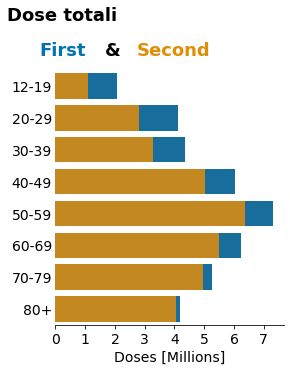

In [24]:
g = sns.FacetGrid(data=overall_age_df, height=4.5, aspect=1)
g.map(sns.barplot, 'prima_dose', 'age', order=AGE_ORDER, color=sns.color_palette('colorblind')[0])
g.map(sns.barplot, 'seconda_dose', 'age', order=AGE_ORDER, color=sns.color_palette('colorblind')[1])
# assert overall_age_df.drop('age', axis=1).max().max() < 7e6+1
g.set(xticks=np.arange(0, 7e6+1, 1e6))
# g.set(xticks=np.arange(0, 1.01, .2))
# g.set_formatter(axis='xaxis', denom=1, fmt='{:.0%}')
g.set_formatter(axis='xaxis', denom=1e6)
g.set_axis_labels(x_var='Doses [Millions]', y_var='')
g.set_subtitle('First', x=.2, y=1, c=0)
g.set_subtitle('&', x=.4, y=1, c='black')
g.set_subtitle('Second', x=.5, y=1, c=1)
g.set_suptitle('Dose totali', x=.1, y=1.15)
g.axes.flatten()[0].tick_params(axis='y', which=u'both',length=0)
g.despine(left=True)

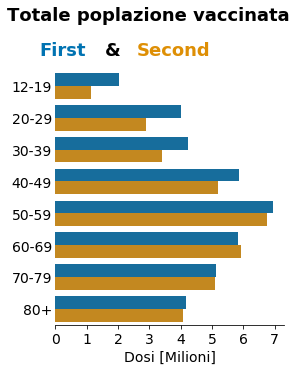

In [25]:
g = sns.FacetGrid(data=overall_age_df.melt(id_vars='age', value_vars=['solo_prima', 'ciclo_completo']), height=4.5, aspect=1)
g.map_dataframe(
    sns.barplot, 'value', 'age', order=AGE_ORDER,
    hue='variable', hue_order=['solo_prima', 'ciclo_completo'], palette='colorblind')
g.set(xticks=np.arange(0, 7e6+1, 1e6))
g.set_formatter(axis='xaxis', denom=1e6)
g.set_axis_labels(x_var='Dosi [Milioni]', y_var='')
g.set_subtitle('First', x=.2, y=1, c=0)
g.set_subtitle('&', x=.4, y=1, c='black')
g.set_subtitle('Second', x=.5, y=1, c=1)
g.set_suptitle('Totale poplazione vaccinata', x=.1, y=1.15)
g.axes.flatten()[0].tick_params(axis='y', which=u'both',length=0)
g.despine(left=True)

# Vaccini per giorno

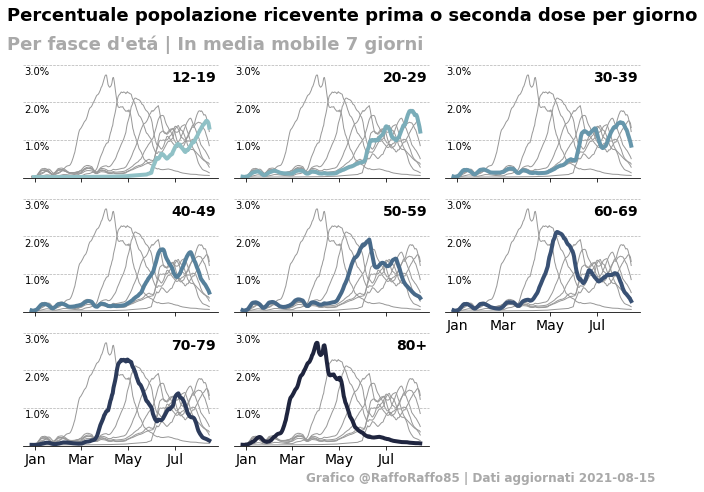

In [26]:
vacc_by_age_df = (
    get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=False, rolling=7)
    .merge(pop_by_age_df, on='fascia_anagrafica')
    .assign(share=lambda x: x.n_vacc*100/x.totale_popolazione)
)
pal = sns.cubehelix_palette(len(AGE_ORDER), rot=-.25, light=.7)
g = sns.FacetGrid(
    data=vacc_by_age_df,
    col="fascia_anagrafica", hue="fascia_anagrafica",
    col_order=AGE_ORDER, hue_order=AGE_ORDER,
    palette=pal,
    col_wrap=3, height=2, aspect=1.5,
)
g.map(sns.lineplot, 'date', 'share', linewidth=4, zorder=5)
for ax in g.axes.flatten():
    fascia_anagrafica = ax.get_title().split(' = ')[1]
    ax.text(.99, .85, fascia_anagrafica, transform=ax.transAxes, fontweight="bold", ha='right')
    sns.lineplot(
        data=vacc_by_age_df, x="date", y="share", units="fascia_anagrafica",
        estimator=None, color=".6", linewidth=1, ax=ax,
    )
    ax.legend_.remove()
    for i in np.arange(1, 3.1):
        ax.axhline(i, ls='--', lw=.7, color='.7', clip_on=False)
        ax.text(ax.get_xlim()[0]+2.5, i-.05, '{}%'.format(i), fontsize=10, ha='left', va='top')
g.set_titles('')
g.set_axis_labels(x_var="", y_var="")
g.set(ylim=(-0.02, 3), yticks=[])
g.set_xdates(START_DATE, END_DATE, fmt='%b', freq='2MS')
g.despine(left=True)
g.fig.tight_layout(h_pad=0)
g.set_suptitle('Percentuale popolazione ricevente prima o seconda dose per giorno')
g.set_subtitle('Per fasce d\'etá | In media mobile 7 giorni')
g.set_subtitle(FOOTNOTE, x=1, y=0, fs=12, ha='right')

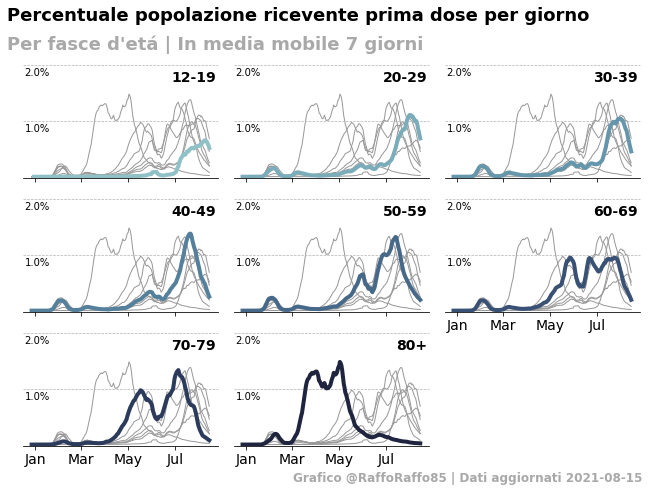

In [27]:
vacc_by_age_df = (
    get_daily_vacc_by_dim(vacc_df, dims=['fascia_anagrafica'], by_dose=True, rolling=7)
    .merge(pop_by_age_df, on='fascia_anagrafica')
    .assign(share=lambda x: x.n_vacc*100/x.totale_popolazione)
    .query('dose=="ciclo completo"')
)
pal = sns.cubehelix_palette(len(AGE_ORDER), rot=-.25, light=.7)
g = sns.FacetGrid(
    data=vacc_by_age_df,
    col="fascia_anagrafica", hue="fascia_anagrafica",
    col_order=AGE_ORDER, hue_order=AGE_ORDER,
    palette=pal,
    col_wrap=3, height=2, aspect=1.5,
)
g.map(sns.lineplot, 'date', 'share', linewidth=4, zorder=5)
for ax in g.axes.flatten():
    fascia_anagrafica = ax.get_title().split(' = ')[1]
    ax.text(.99, .85, fascia_anagrafica, transform=ax.transAxes, fontweight="bold", ha='right')
    sns.lineplot(
        data=vacc_by_age_df, x="date", y="share", units="fascia_anagrafica",
        estimator=None, color=".6", linewidth=1, ax=ax,
    )
    ax.legend_.remove()
    for i in np.arange(1, 2.1):
        ax.axhline(i, ls='--', lw=.7, color='.7', clip_on=False)
        ax.text(ax.get_xlim()[0]+2.5, i-.05, '{}%'.format(i), fontsize=10, ha='left', va='top')
g.set_titles('')
g.set_axis_labels(x_var="", y_var="")
g.set(ylim=(-0.02, 2), yticks=[])
g.set_xdates(START_DATE, END_DATE, fmt='%b', freq='2MS')
g.despine(left=True)
g.fig.tight_layout(h_pad=0)
g.set_suptitle('Percentuale popolazione ricevente prima dose per giorno')
g.set_subtitle('Per fasce d\'etá | In media mobile 7 giorni')
g.set_subtitle(FOOTNOTE, x=.98, y=0, fs=12, ha='right')